In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from unidip import UniDip
from sklearn.mixture import GaussianMixture

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import decode_static

In [2]:
pid = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_009/2020-02-27/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_009'

In [3]:
behave_dict = data_preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = True)
static_behaviors = {'choice': choices, 'stimulus': one_hot_stimuli}

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


In [4]:
rois = [roi.lower() for roi in ['PoT', 'LP', 'DG', 'CA1', 'VIS']]

decode all regions

In [5]:
sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= data_preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=True,
    triage=False
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times_sorted = sorted[:,0]
spike_clusters = sorted[:,1]

sorted_neural_data = data_preprocess.compute_neural_activity(
    (spike_times_sorted, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
1st trial stim on time: 40.81, last trial stim on time 2252.10
sorted neural data shape: (230, 465, 30)


In [6]:
# unsorted_trials, stim_on_times, np1_channel_map = data_preprocess.load_neural_data(
#     pid=pid, 
#     trial_data_path=trial_data_path,
#     neural_data_path=neural_data_path,
#     behavior_data_path=behavior_data_path,
#     keep_active_trials=True, 
#     roi='all',
#     kilosort=False,
#     triage=False
# )

n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times_unsorted = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = data_preprocess.compute_neural_activity(
    (spike_times_unsorted, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=False
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (230, 374, 30)


In [7]:
# gmm_name = '../pretrained/danlab/Subjects/DY_009/init_max_chan_gmm'
gmm_name = '../pretrained/danlab/Subjects/DY_009/kilosort_localizations/init_max_chan_gmm'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
loaded_gmm = GaussianMixture(n_components=len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

spike_labels = loaded_gmm.predict(spike_features)
spike_probs = loaded_gmm.predict_proba(spike_features)

clusterless_neural_data = data_preprocess.compute_neural_activity(
    (spike_times_unsorted, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30,
    regional=False
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (230, 330, 30)


In [8]:
neural_data_dict = {
    'sorted': sorted_neural_data,
    'thresholded': thresholded_neural_data,
    'clusterless': clusterless_neural_data
} 

In [9]:
all_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in all_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type}:')
        decode_results = decode_static.cv_decode_static(
            neural_data_dict[data_type], 
            static_behaviors[behave_type], 
            behave_type=behave_type, 
            n_folds=5, 
            seed=seed, 
            shuffle=True)
        all_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{save_path}/all_decode_results.npy', all_decode_results)

sorted:
choice fold 1 test accuracy: 0.957 auc: 1.000
choice fold 2 test accuracy: 1.000 auc: 1.000
choice fold 3 test accuracy: 1.000 auc: 1.000
choice fold 4 test accuracy: 0.957 auc: 0.990
choice fold 5 test accuracy: 0.913 auc: 0.984
choice mean of 5-fold cv accuracy: 0.965 auc: 0.995
choice sd of 5-fold cv accuracy: 0.033 auc: 0.007
thresholded:
choice fold 1 test accuracy: 0.957 auc: 1.000
choice fold 2 test accuracy: 0.978 auc: 1.000
choice fold 3 test accuracy: 1.000 auc: 1.000
choice fold 4 test accuracy: 0.935 auc: 0.992
choice fold 5 test accuracy: 0.913 auc: 0.984
choice mean of 5-fold cv accuracy: 0.957 auc: 0.995
choice sd of 5-fold cv accuracy: 0.031 auc: 0.006
clusterless:
choice fold 1 test accuracy: 0.957 auc: 1.000
choice fold 2 test accuracy: 0.978 auc: 1.000
choice fold 3 test accuracy: 1.000 auc: 1.000
choice fold 4 test accuracy: 0.978 auc: 0.990
choice fold 5 test accuracy: 0.913 auc: 0.986
choice mean of 5-fold cv accuracy: 0.965 auc: 0.995
choice sd of 5-fold 

decode brain regions

In [35]:
roi = rois[4]
print(roi)

vis


In [36]:
sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= data_preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi=roi,
    kilosort=True,
    triage=False
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times_sorted = sorted[:,0]
spike_clusters = sorted[:,1]

sorted_neural_data = data_preprocess.compute_neural_activity(
    (spike_times_sorted, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
1st trial stim on time: 40.81, last trial stim on time 2252.10
found 29 neurons in region vis ...
found 40 channels in region vis ...
sorted neural data shape: (230, 29, 30)


In [37]:
# unsorted_trials, stim_on_times, np1_channel_map = data_preprocess.load_neural_data(
#     pid=pid, 
#     trial_data_path=trial_data_path,
#     neural_data_path=neural_data_path,
#     behavior_data_path=behavior_data_path,
#     keep_active_trials=True, 
#     roi=roi,
#     kilosort=False,
#     triage=False
# )

n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times_unsorted = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = data_preprocess.compute_neural_activity(
    (spike_times_unsorted, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=True
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (230, 15, 30)


In [38]:
gmm_name = '../pretrained/danlab/Subjects/DY_009/kilosort_localizations/init_max_chan_gmm'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
loaded_gmm = GaussianMixture(n_components=len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

spike_labels = loaded_gmm.predict(spike_features)
spike_probs = loaded_gmm.predict_proba(spike_features)

clusterless_neural_data = data_preprocess.compute_neural_activity(
    (spike_times_unsorted, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30,
    regional=True
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (230, 29, 30)


In [39]:
neural_data_dict = {
    'sorted': sorted_neural_data,
    'thresholded': thresholded_neural_data,
    'clusterless': clusterless_neural_data
} 

In [40]:
regional_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in regional_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type}:')
        decode_results = decode_static.cv_decode_static(
            neural_data_dict[data_type], 
            static_behaviors[behave_type], 
            behave_type=behave_type, 
            n_folds=5, 
            seed=seed, 
            shuffle=True)
        regional_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{save_path}/{roi}_decode_results.npy', regional_decode_results)

sorted:
choice fold 1 test accuracy: 0.761 auc: 0.773
choice fold 2 test accuracy: 0.870 auc: 0.900
choice fold 3 test accuracy: 0.826 auc: 0.935
choice fold 4 test accuracy: 0.761 auc: 0.817
choice fold 5 test accuracy: 0.804 auc: 0.813
choice mean of 5-fold cv accuracy: 0.804 auc: 0.848
choice sd of 5-fold cv accuracy: 0.041 auc: 0.060
thresholded:
choice fold 1 test accuracy: 0.652 auc: 0.762
choice fold 2 test accuracy: 0.804 auc: 0.865
choice fold 3 test accuracy: 0.870 auc: 0.897
choice fold 4 test accuracy: 0.696 auc: 0.779
choice fold 5 test accuracy: 0.739 auc: 0.870
choice mean of 5-fold cv accuracy: 0.752 auc: 0.835
choice sd of 5-fold cv accuracy: 0.077 auc: 0.053
clusterless:
choice fold 1 test accuracy: 0.783 auc: 0.796
choice fold 2 test accuracy: 0.783 auc: 0.879
choice fold 3 test accuracy: 0.848 auc: 0.905
choice fold 4 test accuracy: 0.826 auc: 0.856
choice fold 5 test accuracy: 0.804 auc: 0.872
choice mean of 5-fold cv accuracy: 0.809 auc: 0.862
choice sd of 5-fold 

decode choice

In [ ]:
viz_tools.plot_compare_decoder_barplots(
    save_path + '/kilosort_localizations',
    behave_type='choice', 
    metric_type='auc', 
    rois=rois, 
    n_folds=5, 
    add_smooth=False, 
    figure_size=(8,8), 
    font_size=15, 
    title='DY-009: choice',
    save_fig=True,
    fig_path='../saved_figs/danlab/Subjects/DY_009',
)

decode stimulus

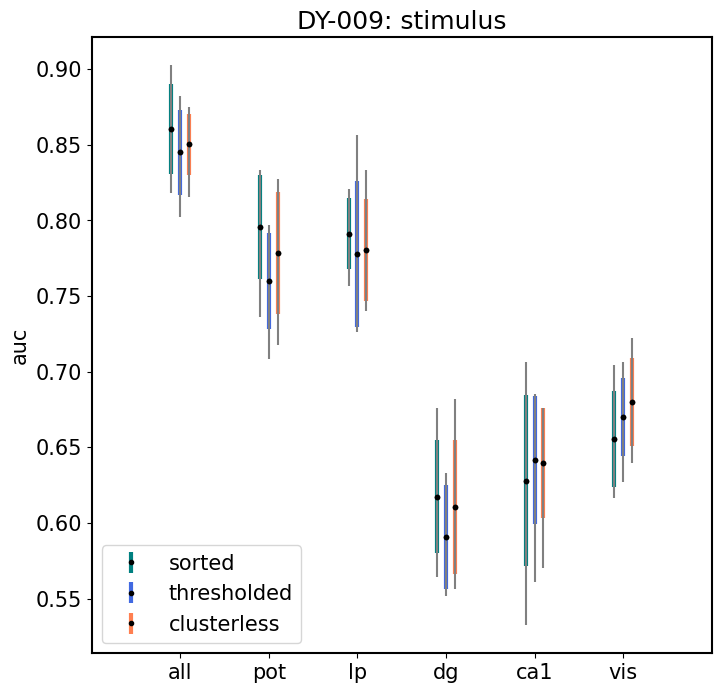

In [9]:
viz_tools.plot_compare_decoder_barplots(
    save_path + '/kilosort_localizations',
    behave_type='stimulus', 
    metric_type='auc', 
    rois=rois, 
    n_folds=5, 
    add_smooth=False, 
    figure_size=(8,8), 
    font_size=15, 
    title='DY-009: stimulus',
    save_fig=True,
    fig_path = '../saved_figs/danlab/Subjects/DY_009',
)